In [1]:

%load_ext autoreload
%autoreload 2

Procedure

- Create mesh
    - Generates object with nodes and elements as properties
    - Depends on coordinate system, mesh size, and symmetry conditions
- Add structures 
    - 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

- Check get_plane_node_ids to see if 0s are necessary
- Fix formatting of numbers in material cards
- Fix pml/struct interface with 4 node overlap 
    - Check len(pml_and_struct_nodes) condition is valid
- Add validation functions
    - Nodes exist on center axis regardless of mesh symmetry so peak arf load is modeled
    - Mesh extent minima are less than maxima
- Add card dictionary/dataclass to contain all dyna cards and defaults
    - Materials
    - Load curves
    - Loads (nodal forces list)
    - Database
    - Master keyword file
- Add nested and unnested folder structure write out options
    - Unnested: all files in same folder for single simulation
    - Nested: folder structure for batch simulations:
        project/mesh.dyn
               /index file 
               /load_folders/arf_load.dyn
                            /material_folders/materials.dyn
                                             /master.dyn
    - Create reader/writer for loading the index file and extracting simulation data. Use generic folder names (arf_load_x, material_x) and keep variable parameters associated with folder x in index file

- Create mesh 
    - Depends on element size and extents
    - Returns coordinate axes (size of each is nx, ny, nz)
- Add structures to mesh
    - Get nodes in struct based on coordinates
    - Change part id of elements in struct
        - All nodes in element should be within struct? 
    -- Generate list of node ids in struct
- Add boundary constraints 
    - Depends on mesh symmetry
    - Change tc and rc of nodes on faces and edges
- Add pml
    - Depends on mesh symmetry and pml thickness
    - Change part id of non-symmetry plane elements
    - Part id + 1 if also in struct
- Finish dyna deck
    - Add material
    - Add load curves
    - Add arf load based on field params (pre-generated)
    - Add database/control parameters
        - Node sets?
- Validation functions
    - Make sure nodes exist on center axis regardless of mesh symmetry so peak arf load is modeled



In [ ]:
# @dataclass
# class Extent:
#     x: Tuple[float, float]
#     y: Tuple[float, float]
#     z: Tuple[float, float]

# @dataclass
# class Coordinates:
#     nx: int
#     ny: int
#     nz: int
#     extent: Extent
#     x: np.ndarray = field(init=False, repr=False)
#     y: np.ndarray = field(init=False, repr=False)
#     z: np.ndarray = field(init=False, repr=False)

#     def __post_init__(self):
#         self.x = np.linspace(self.extent.x[0], self.extent.x[1], self.nx)
#         self.y = np.linspace(self.extent.y[0], self.extent.y[1], self.ny)
#         self.z = np.linspace(self.extent.z[0], self.extent.z[1], self.nz)


In [68]:
import fem
import pathlib

from fem.dyna.mesh import Coordinates, DynaMesh
from fem.dyna._structure import Structure
from fem.dyna.material import KelvinMaxwellViscoelastic

project_path = pathlib.Path(fem.__file__).parents[1]

mat1 = KelvinMaxwellViscoelastic(density=1, E=26.11, nu=0.499, eta=2.34)
mat2 = KelvinMaxwellViscoelastic(density=1, E=2*26.11, nu=0.499, eta=2.34)

struct_list = [
    Structure(
        shape = 'rectangle', 
        args = [-1, -0.5, -0.5, -0, -4, -2],
        material = mat2,  
    ), 
    # Structure(
    #     shape = 'sphere', 
    #     args = [0, 0, -2, 1],
    #     material = mat2,  
    # ), 
]

coords = Coordinates(
    nx=3, ny=51, nz=101,
    xmin=-1.0, xmax=0.0,  # ele
    ymin=0.0, ymax=0.5,  # lat
    zmin=-4.0, zmax=-0.15   # ax
)
symmetry = 'q'
mesh = DynaMesh(coords, symmetry, mat1)

mesh.constrain_boundary_nodes()
mesh.add_pml(pml_thickness=2, exclude_faces=['zmin'])
mesh.add_struct_list(struct_list)

mesh.set_control(end_time=4.5e-3)
mesh.set_database(dt=2e-5)
mesh.set_master(title='testing')

load_curve_id = 1
normalization_isppa = 1000
field_load_file = project_path.joinpath('loads/test_loads.mat')
mesh.add_load_curve(load_curve_id, 'arf', [70e-6, 5e-6])
mesh.add_field_arf_load(field_load_file, normalization_isppa, load_curve_id)

load_folder_name = 'load_0'
material_folder_name = 'material_0'
mesh.write_all_dyna_cards(project_path, load_folder_name, material_folder_name)


In [20]:
import pathlib
import fem
from scipy.io import loadmat

load_path = pathlib.Path(fem.__file__).parents[1].joinpath('loads')
# mat_file = load_path / 'f2dout.mat'
mat_file = load_path / 'test_loads.mat'

mat = loadmat(mat_file)
c = mat['FIELD_PARAMS']['soundSpeed'][0,0][0][0]*100 # convert from m/s to cm/s
alpha_db = mat['FIELD_PARAMS']['alpha'][0,0][0][0]
frequency = mat['FIELD_PARAMS']['Frequency'][0,0][0][0]
alpha_np = alpha_db * frequency / 8.616

normalization_isppa = 1000  # W/cm^2

node_ids, intensity = mesh.interpolate_field_to_dyna_intensities(mat_file)
point_loads = mesh.calculate_point_loads_from_field_intensities(intensity, normalization_isppa, alpha_np, c)
print(node_ids.shape, intensity.shape, point_loads.shape)

(15453,) (15453,) (15453,)


In [51]:
print(point_loads[10630])
print(point_loads[10640])

0.25199192536573867
1.3229349794077825


In [42]:
10 + 2 + 1 - 10

3

In [72]:
from fem.dyna._writer import format_dyna_number

test_number_list = [
    0.00002,
    232094812390411,
    -232094812390411,
    0.101802301e-10,
    -0.101802301e-10,
    point_loads[10630],
    -point_loads[10640],
    1,
    0.0,
    10000102
]

for n in test_number_list:
    snum = format_dyna_number(n)
    print(f"{len(snum)}, {snum}, {n}\n")

5, 2e-05, 2e-05

10, 2.3209E+14, 232094812390411

10, -2.320E+14, -232094812390411

10, 1.0180E-11, 1.01802301e-11

10, -1.018E-11, -1.01802301e-11

10, 0.25199193, 0.25199192536573867

10, -1.3229350, -1.3229349794077825

1, 1, 1

3, 0.0, 0.0

8, 10000102, 10000102



In [31]:
mat['FIELD_PARAMS'].dtype

dtype([('measurementPointsandNodes', 'O'), ('measurementPoints', 'O'), ('alpha', 'O'), ('Fnum', 'O'), ('focus', 'O'), ('Frequency', 'O'), ('Transducer', 'O'), ('Impulse', 'O'), ('soundSpeed', 'O'), ('samplingFrequency', 'O'), ('lat_extent', 'O'), ('ele_extent', 'O'), ('ax_extent', 'O')])

In [32]:
normalization_isppa = 1000

mat = loadmat(mat_file)
c = mat['FIELD_PARAMS']['soundSpeed'][0,0][0][0]*100 # convert from m/s to cm/s
alpha_db = mat['FIELD_PARAMS']['alpha'][0,0][0][0]
frequency = mat['FIELD_PARAMS']['Frequency'][0,0][0][0]
alpha_np = alpha_db * frequency / 8.616

field_isppa = np.max(intensity)
intensity = intensity / field_isppa

# toss intensities below 5% of Isppa
intensity[intensity < 0.05] = 0

# now zero out values near the transducer face b/c they
# violated the farfield assumption in field
coords = mesh.coords.flatten()
intensity[np.isclose(coords[:,2], 0, atol=0.001)] = 0

# normalize
intensity = intensity * normalization_isppa

# convert intensities from Watts to cgs units
intensity = intensity * 10000000

# Calculate force from F = (2*alpha*I)/c 
body_forces = (2 * alpha_np * intensity) / c
point_loads = body_forces * mesh.get_element_volume()

if sym == 'q':
    # if the load is on the symmetry axis (x = y = 0), then divide by 4; if
    # not, check if it is on a symmetry face (x = 0 || y = 0), then divide
    # by 2
    idxq = np.isclose(coords[:,0], 0, atol=1e-4) & np.isclose(coords[:,1], 0, atol=1e-4)
    point_loads[idxq] = point_loads[idxq] / 4
    idxh = np.isclose(coords[:,0], 0, atol=1e-4) ^ np.isclose(coords[:,1], 0, atol=1e-4)
    point_loads[idxh] = point_loads[idxh] / 2
elif sym == 'hy':
    # if the load is on the symmetry face (y=0), then divide by 2
    idxh = np.isclose(coords[:,1], 0, atol=1e-4) 
    point_loads[idxh] = point_loads[idxh] / 2
elif sym == 'hx':
    # if the load is on the symmetry face (x=0), then divide by 2
    idxh = np.isclose(coords[:,0], 0, atol=1e-4) 
    point_loads[idxh] = point_loads[idxh] / 2

NameError: name 'sym' is not defined

In [25]:
npoints = (mesh.coords.nx, mesh.coords.ny, mesh.coords.nz)
intensity_3d = intensity.reshape(*npoints)


array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int64)

(262701,)


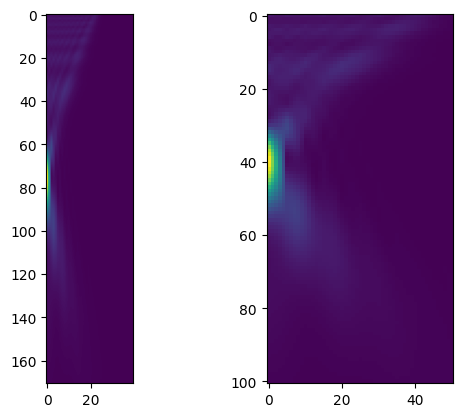

In [17]:
from scipy.interpolate import interpn
from itertools import product
from scipy.io import loadmat
import pathlib
import fem

load_path = pathlib.Path(fem.__file__).parents[1].joinpath('loads')
# mat_file = load_path / 'f2dout.mat'
mat_file = load_path / 'test_loads.mat'
# mat_file = load_path / 'vf73_intensityMap_reference.mat'
mat = loadmat(mat_file)

extent = dict(
    lat=mat['FIELD_PARAMS']['lat_extent'][0,0].reshape(-1,),
    ele=mat['FIELD_PARAMS']['ele_extent'][0,0].reshape(-1,),
    ax=mat['FIELD_PARAMS']['ax_extent'][0,0].reshape(-1,),
)

nlat, nele, nax = len(extent['lat']), len(extent['ele']), len(extent['ax'])
intensity = mat['intensity'].reshape(nax, nlat, nele)
intensity = np.swapaxes(intensity, 0, 2)
intensity = np.flip(intensity, axis=2)

dyna_points = mesh.coords.flatten()
npoints = (mesh.coords.nx, mesh.coords.ny, mesh.coords.nz)

field_points = (extent['ele']*1e2, extent['lat']*1e2, -extent['ax']*1e2)

intensity_interp = interpn(field_points, intensity, dyna_points)
print(intensity_interp.shape)
intensity_interp = intensity_interp.reshape(*npoints)

plt.subplot(121)
plt.imshow(intensity[-1,:,:].T)
plt.subplot(122)
plt.imshow(intensity_interp[-1,:,:].T)

In [19]:
np.arange(1, mesh.n_nodes + 1).shape

(262700,)